## 2D Marsh Erosion

#### Set up a small 8 x 7 test grid with marsh cells in the middle.

The indexing is [column,row], with column indices from 0 (south) to 7 (north), and row indices from 0 (west) to 6 (east).

The marsh mask is a real number representing the horizontal area covered by marsh.
If it is below a small value (0.001), the cell is collapsed and considered wet.

The erosion rate has a constant, uniform magnitude.

#### Run the marsh cell book-keeping

Here are the steps programmed below:
* Set up the domain and initialize elevations and the marsh mask
* Calculate the scarp heights at the marsh edges
* For each time step:
    * Calculate the scarp retreat rate (in reality, a function of waves, adjacent water depths, and maybe scarp height)
    * Ensure that total scarp retreat is less than dx, dy, and average e-w and n-s rates to get corners right.
    * Calculate volumes using retreat distance and scarp height (could us another number, like erodible thickness)
    * Convert volume to mass. Remove mass from marsh cell and distribute to adjacent cells.
    * Update marsh mask. If cell is no longer marsh, collapse to tidal flat.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Marsh Erosion in 2D
dx = 100.
dy = 100.
nx = 7
ny = 8

# center points
xc = np.arange(0,nx)*dx + dx/2. # row vector
yc = np.arange(0,ny).reshape((ny,1))*dy + dy/2. # col vector

# replicate to make 2D arrays
xc = np.tile(xc,(ny,1))
yc = np.tile(yc,(1,nx))
print("Shape of xc",np.shape(xc))
print("Shape of yc",np.shape(yc))

# marsh mask
mmask = np.zeros((ny,nx))
mmask[2:5,2:5]=1.

# uniform elevations to domain
dz = .5*np.ones_like(mmask)

# ...but make marsh cells taller
dz[mmask>0.]=2.
print(dz)

# arrays for cumulative e-w and n-s erosion
xm = np.zeros_like(mmask)
ym = np.zeros_like(mmask)

Shape of xc (8, 7)
Shape of yc (8, 7)
[[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]]


In [2]:
# Scarp height arrays - these are like u, v arrays
zmx = np.zeros((ny,nx+1))
zmy = np.zeros((ny+1,nx))
# calculate scarp heights
for iy in range(ny):
    zmx[iy,1:nx]=np.diff(dz[iy,:])
    
for ix in range(nx):
    zmy[1:ny,ix]=np.diff(dz[:,ix])
    
print(zmx)
print(zmy)

[[ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.5  0.   0.  -1.5  0.   0. ]
 [ 0.   0.   1.5  0.   0.  -1.5  0.   0. ]
 [ 0.   0.   1.5  0.   0.  -1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.5  1.5  1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.5 -1.5 -1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]]


In [3]:
# Calculate initial volume and mass
rhos = 2650.
cb = 0.5
V = dx*dy*dz
M = (1.-cb)*rhos*V

tt = 25*24.*3600.        # 25 days
dt = 24.*3600.           # dt = 1 day
nt = int(np.ceil(tt/dt)) # number of times

# array for tracking total mass
M_a =  np.nan*np.ones((nt))
M_a[0]=np.sum(M)

# Run
for i in range(nt):
    
    # calculate scarp heights (retain sign of change)
    for iy in range(ny):
        zmx[iy,1:nx]=np.diff(dz[iy,:])
    
    for ix in range(nx):
        zmy[1:ny,ix]=np.diff(dz[:,ix])
    
    # make uniform arrays of erosion distance magnitude (always shoreward)
    dxm = dt*300./(3600.*24.*365.)*np.ones_like(zmx)
    dym = dt*300./(3600.*24.*365.)*np.ones_like(zmy)
    
    for ix in range(nx):
        for iy in range(ny):
            # only do these operations in a cell masked as marsh adjacent to a not-marsh cell
            # (this is klunky, but necessary because of the uniform erosion rate)
            if(mmask[iy,ix]>0.001 and np.any(np.array([mmask[iy-1,ix],mmask[iy+1,ix],mmask[iy,ix+1],mmask[iy,ix-1]])<0.001)):
                dxw = dxm[iy,ix]
                dxe = dxm[iy,ix+1]
                dys = dym[iy,ix]
                dyn = dym[iy+1,ix]
                
                # temporary value for cumulative erosion
                xmt = xm[iy,ix]+(dxw+dxe)
                ymt = ym[iy,ix]+(dys+dyn)
                
                # if cumulative erosion is bigger than the e-w cell size, reduce proportionately
                if(xmt>dx):
                    dxe = dx*dxe/(dx-(dxw+dxe+xm[iy,ix]))
                    dxw = dx*dxw/(dx-(dxw+dxe+xm[iy,ix]))

                # if cumulative erosion is bigger than the n-s cell size, reduce proportionately
                if(ymt>dy):
                    dyn = dy*dyn/(dy-(dyn+dys+ym[iy,ix]))
                    dys = dy*dys/(dy-(dyn+dys+ym[iy,ix]))
                    
                # new values for cumulative erosion (should never exceed dx, dy)
                xm[iy,ix] += dxw+dxe
                ym[iy,ix] += dys+dyn
                
                # volumes eroded - this is the average of eroding e-w first and n-s second and vice versa
                # TODO: make erosion zero if marsh is lower than adjacent cell
                vxw = dxw*np.abs(zmx[iy,ix])  *0.5*(dy+(dy-(dyn+dys)))
                vxe = dxe*np.abs(zmx[iy,ix+1])*0.5*(dy+(dy-(dyn+dys)))
                vys = dys*np.abs(zmy[iy,ix])  *0.5*(dx+(dx-(dxw+dxe)))
                vyn = dyn*np.abs(zmy[iy+1,ix])*0.5*(dx+(dx-(dxw+dxe)))
                #print(iy,ix,"\n",dxe,dxw,dys,dyn,'\n',vxw,vxe,vys,vyn)
                
                # subtract mass from eroding marsh cell
                M[iy,ix] -= (vxw+vxe+vys+vyn)*(1-cb)*rhos
                
                # add mass to adjacent cells
                # TODO treat corner cell?
                M[iy,ix-1] += vxw*(1-cb)*rhos
                M[iy,ix+1] += vxe*(1-cb)*rhos
                M[iy-1,ix] += vys*(1-cb)*rhos
                M[iy+1,ix] += vyn*(1-cb)*rhos
                
                # update horiz marsh cell fraction
                mmask[iy,ix] = (1. - (xm[iy,ix]/dx + ym[iy,ix]/dy))
    
                if (mmask[iy,ix]<=0.001) :
                    mmask[iy,ix]=0.
                    dz[iy,ix]=M[iy,ix]/((1-cb)*rhos*dx*dy)
                
    # total mass in system
    M_a[i]=np.sum(M)
    
print("Initial mass: {}\nFinal mass  : {}".format(M_a[0],M_a[-1]))

Initial mass: 549875000.0
Final mass  : 549875000.0


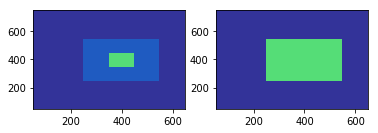

In [4]:
plt.subplot(2,2,1); plt.pcolor(xc,yc,mmask,cmap=plt.cm.terrain,vmin=0.,vmax=3.)
plt.subplot(2,2,2);plt.pcolor(xc,yc,dz,cmap=plt.cm.terrain,vmin=1,vmax=4)

In [5]:
print(mmask)
print(dz)

[[ 0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.17808219  0.17808219  0.17808219  0.          0.        ]
 [ 0.          0.          0.17808219  1.          0.17808219  0.          0.        ]
 [ 0.          0.          0.17808219  0.17808219  0.17808219  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.        ]]
[[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]

In [6]:
# test any
iy = 2; ix = 3;
print(mmask[iy,ix])
np.any(np.array([mmask[iy-1,ix],mmask[iy+1,ix],mmask[iy,ix+1],mmask[iy,ix-1]])<0.001)

0.178082191781


True